In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
cad = pd.read_csv('GMU_2021_Summer_CAD.csv')
avl = pd.read_csv('GMU_2021_Summer_AVL.csv')
avl.columns = ['AVL_IncidentNumber',
               'AVL_UnitID',
               'AVL_Timestamp',
               'AVL_UnitStatus',
               'AVL_Speed']
avl.dropna(subset = ['AVL_IncidentNumber'],
           inplace = True)
avl.reset_index(inplace = True, drop = True)
avl.isna().sum()

AVL_IncidentNumber    0
AVL_UnitID            0
AVL_Timestamp         0
AVL_UnitStatus        0
AVL_Speed             0
dtype: int64

In [3]:
# convert object to timestamp proper
avl['AVL_Timestamp'] = avl['AVL_Timestamp'].str.replace('ED', '')
cad['CAD_Timestamp'] = cad['CAD_Timestamp'].str.replace('ED', '')
avl['AVL_Timestamp'] = avl['AVL_Timestamp'].str.replace('ES', '')
cad['CAD_Timestamp'] = cad['CAD_Timestamp'].str.replace('ES', '')
avl['AVL_Timestamp'] = pd.to_datetime(avl['AVL_Timestamp'], format = '%Y%m%d%H%M%S')
cad['CAD_Timestamp'] = pd.to_datetime(cad['CAD_Timestamp'], format = '%Y%m%d%H%M%S')

In [4]:
#Create separate dat sets of ER and DP to then be joined to to form "transport" entry
cad_er = cad[cad['CAD_UnitStatus'].isin(['ER'])]
cad_dp= cad[cad['CAD_UnitStatus'].isin(['DP'])]
avl_er = avl[avl['AVL_UnitStatus'].isin(['ER'])]
avl_dp= avl[avl['AVL_UnitStatus'].isin(['DP'])]

In [5]:
#rename the columns so that that are labeled CAD or AVL and er or dp data frame
cad_er=cad_er.rename(columns={"CAD_IncidentNumber":"cad_er_IncidentNumber","CAD_UnitID":"cad_er_UnitID","CAD_Timestamp":"cad_er_Timestamp", "CAD_UnitStatus":"cad_er_UnitStatus"})
cad_dp=cad_dp.rename(columns={"CAD_IncidentNumber":"cad_dp_IncidentNumber","CAD_UnitID":"cad_dp_UnitID","CAD_Timestamp":"cad_dp_Timestamp", "CAD_UnitStatus":"cad_dp_UnitStatus"})

avl_er=avl_er.rename(columns={"AVL_IncidentNumber":"avl_er_IncidentNumber","AVL_UnitID":"avl_er_UnitID","AVL_Timestamp":"avl_er_Timestamp", "AVL_UnitStatus":"avl_er_UnitStatus", "AVL_Speed":"avl_er_Speed"})
avl_dp=avl_dp.rename(columns={"AVL_IncidentNumber":"avl_dp_IncidentNumber","AVL_UnitID":"avl_dp_UnitID","AVL_Timestamp":"avl_dp_Timestamp", "AVL_UnitStatus":"avl_dp_UnitStatus", "AVL_Speed":"avl_dp_Speed"})

In [6]:
#Create the FullKey to make sure the first time entry for the ER and DP status are being taken
cad_er['cad_er_FullKey'] = cad_er['cad_er_IncidentNumber'].map(str) +  cad_er['cad_er_UnitID'].map(str)
cad_dp['cad_dp_FullKey'] = cad_dp['cad_dp_IncidentNumber'].map(str) +  cad_dp['cad_dp_UnitID'].map(str)

avl_er['avl_er_FullKey'] = avl_er['avl_er_IncidentNumber'].map(str) +  avl_er['avl_er_UnitID'].map(str)
avl_dp['avl_dp_FullKey'] = avl_dp['avl_dp_IncidentNumber'].map(str) +  avl_dp['avl_dp_UnitID'].map(str)

#for validation note that there are currently duplicates in the data frames
dups_cad_er = cad_er.pivot_table(index = ['cad_er_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_cad_er)
dups_cad_dp = cad_dp.pivot_table(index = ['cad_dp_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_cad_dp)

dups_avl_er = avl_er.pivot_table(index = ['avl_er_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_avl_er)
dups_avl_dp = avl_dp.pivot_table(index = ['avl_dp_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_avl_dp)

In [7]:
#sort both dataframes by timestamp so when dups are removed taking the first time stamp
cad_er.sort_values(by='cad_er_Timestamp', ascending=True)
cad_dp.sort_values(by='cad_dp_Timestamp', ascending=True)

avl_er.sort_values(by='avl_er_Timestamp', ascending=True)
avl_dp.sort_values(by='avl_dp_Timestamp', ascending=True)

#Remove duplicates from each dataframe, so each unit ID is only DP or ER to an incident once
cad_er_NEW = cad_er.drop_duplicates(subset='cad_er_FullKey', keep="first", inplace=False)
cad_dp_NEW = cad_dp.drop_duplicates(subset='cad_dp_FullKey', keep="first", inplace=False)

avl_er_NEW = avl_er.drop_duplicates(subset='avl_er_FullKey', keep="first", inplace=False)
avl_dp_NEW = avl_dp.drop_duplicates(subset='avl_dp_FullKey', keep="first", inplace=False)

In [8]:
#For Validation confirm that there are NOT currently duplicate values
dups_cad_er_NEW = cad_er_NEW.pivot_table(index = ['cad_er_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_cad_er_NEW)
dups_cad_dp_NEW = cad_dp_NEW.pivot_table(index = ['cad_dp_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_cad_dp_NEW)

dups_avl_er_NEW = avl_er_NEW.pivot_table(index = ['avl_er_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_avl_er_NEW)
dups_avl_dp_NEW = avl_dp_NEW.pivot_table(index = ['avl_dp_FullKey'], aggfunc ='size').sort_values(ascending=False)
# print(dups_avl_dp_NEW)

In [9]:
#join the CAD data framaes together and then the AVL dataframes together
df_cad = cad_dp_NEW.merge(cad_er_NEW, 
               how = 'inner', 
               left_on = ['cad_dp_IncidentNumber',
                          'cad_dp_UnitID'],
               right_on = ['cad_er_IncidentNumber',
                           'cad_er_UnitID'],
               suffixes = ('cad_dp', 'cad_er'))

df_avl = avl_dp_NEW.merge(avl_er_NEW, 
               how = 'inner', 
               left_on = ['avl_dp_IncidentNumber',
                          'avl_dp_UnitID'],
               right_on = ['avl_er_IncidentNumber',
                           'avl_er_UnitID'],
               suffixes = ('avl_dp', 'avl_er'))

In [10]:
# create turnout col in merged dataframe
df_cad['cad_Timestamp_Turnout'] = abs(df_cad['cad_er_Timestamp'] - df_cad['cad_dp_Timestamp'])

df_avl['avl_Timestamp_Turnout'] = abs(df_avl['avl_er_Timestamp'] - df_avl['avl_dp_Timestamp'])

In [11]:
#convert the turnout time into seconds for simplier analysis
df_CADless60 = df_cad[df_cad['cad_Timestamp_Turnout'].dt.total_seconds() <= 60]
df_AVLless60 = df_avl[df_avl['avl_Timestamp_Turnout'].dt.total_seconds() <= 60]

In [12]:
# #Different Analytics
# df_cad.info()
# df_CADless60.info()
# 516138/822376
# #about 63% of incidents had a turnout time of 60 seconds or less in CAD dataset

# df_avl.info()
# df_AVLless60.info()
# 23061/44420
# #only about 52% of incidents had a turnout time of 60 seconds or less in CAD dataset

In [13]:
df_avl["avl_Timestamp_Turnout"].mean()

Timedelta('0 days 00:03:37.305920756')

In [14]:
df_cad["cad_Timestamp_Turnout"].mean()

Timedelta('0 days 00:01:17.788538332')

In [15]:
df_cad["cad_Timestamp_Turnout"].max()

Timedelta('11 days 05:19:44')

In [16]:
df_avl["avl_Timestamp_Turnout"].max()

Timedelta('11 days 05:24:47')

In [17]:
df_cad["cad_Timestamp_Turnout"].min()

Timedelta('0 days 00:00:00')

In [18]:
df_avl["avl_Timestamp_Turnout"].min()

Timedelta('0 days 00:00:00')

In [19]:
df_cad[df_cad['cad_Timestamp_Turnout'].isin(['0 days 00:00:00'])].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28855 entries, 45 to 822343
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   cad_dp_IncidentNumber  28855 non-null  object         
 1   cad_dp_UnitID          28855 non-null  object         
 2   cad_dp_Timestamp       28855 non-null  datetime64[ns] 
 3   cad_dp_UnitStatus      28855 non-null  object         
 4   cad_dp_FullKey         28855 non-null  object         
 5   cad_er_IncidentNumber  28855 non-null  object         
 6   cad_er_UnitID          28855 non-null  object         
 7   cad_er_Timestamp       28855 non-null  datetime64[ns] 
 8   cad_er_UnitStatus      28855 non-null  object         
 9   cad_er_FullKey         28855 non-null  object         
 10  cad_Timestamp_Turnout  28855 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), object(8), timedelta64[ns](1)
memory usage: 2.6+ MB


In [20]:
df_avl[df_avl['avl_Timestamp_Turnout'].isin(['0 days 00:00:00'])].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 998 to 36197
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   avl_dp_IncidentNumber  40 non-null     object         
 1   avl_dp_UnitID          40 non-null     object         
 2   avl_dp_Timestamp       40 non-null     datetime64[ns] 
 3   avl_dp_UnitStatus      40 non-null     object         
 4   avl_dp_Speed           40 non-null     object         
 5   avl_dp_FullKey         40 non-null     object         
 6   avl_er_IncidentNumber  40 non-null     object         
 7   avl_er_UnitID          40 non-null     object         
 8   avl_er_Timestamp       40 non-null     datetime64[ns] 
 9   avl_er_UnitStatus      40 non-null     object         
 10  avl_er_Speed           40 non-null     object         
 11  avl_er_FullKey         40 non-null     object         
 12  avl_Timestamp_Turnout  40 non-null     timedelt

In [21]:
df_cad[df_cad['cad_Timestamp_Turnout'].isin(['11 days 05:19:44'])]

,cad_dp_IncidentNumber,cad_dp_UnitID,cad_dp_Timestamp,cad_dp_UnitStatus,cad_dp_FullKey,cad_er_IncidentNumber,cad_er_UnitID,cad_er_Timestamp,cad_er_UnitStatus,cad_er_FullKey,cad_Timestamp_Turnout
206080,E170333099,R419,2017-02-14 02:30:56,DP,E170333099R419,E170333099,R419,2017-02-02 21:11:12,ER,E170333099R419,11 days 05:19:44


In [22]:
df_avl[df_avl['avl_Timestamp_Turnout'].isin(['11 days 05:24:47'])]

,avl_dp_IncidentNumber,avl_dp_UnitID,avl_dp_Timestamp,avl_dp_UnitStatus,avl_dp_Speed,avl_dp_FullKey,avl_er_IncidentNumber,avl_er_UnitID,avl_er_Timestamp,avl_er_UnitStatus,avl_er_Speed,avl_er_FullKey,avl_Timestamp_Turnout
14726,E170333099,R419,2017-02-14 02:37:33,DP,not moving,E170333099R419,E170333099,R419,2017-02-02 21:12:46,ER,moving,E170333099R419,11 days 05:24:47


In [23]:
cad_SORT = cad.sort_values('CAD_Timestamp').groupby(['CAD_IncidentNumber','CAD_UnitID','CAD_UnitStatus'])['CAD_Timestamp'].agg(['first'])

In [24]:
avl_SORT = avl.sort_values('AVL_Timestamp').groupby(['AVL_IncidentNumber','AVL_UnitID','AVL_UnitStatus'])['AVL_Timestamp'].agg(['first'])

In [25]:
cad_SORT = cad_SORT.reset_index()

In [26]:
avl_SORT = avl_SORT.reset_index()

In [27]:
cad_SORT.head()

,CAD_IncidentNumber,CAD_UnitID,CAD_UnitStatus,first
0,70018,M401,TA,2020-08-29 11:46:22
1,70018,M401,UC,2020-08-29 12:44:57
2,70018,M401,UE,2020-08-29 12:44:56
3,70018,M401,UU,2020-08-29 12:44:56
4,70135,E413,ER,2017-05-24 08:08:45


In [28]:
avl_SORT.head()

,AVL_IncidentNumber,AVL_UnitID,AVL_UnitStatus,first
0,E163662437,M429,TA,2017-01-01 00:09:23
1,E163662542,E429,OS,2017-01-01 00:02:00
2,E163662542,TT429,OS,2017-01-01 00:02:14
3,E163662548,M404,TA,2017-01-01 00:18:41
4,E163662548,M404,TR,2017-01-01 00:05:04


In [29]:
sort = avl_SORT.merge(cad_SORT, 
               how = 'inner', 
               left_on = ['AVL_IncidentNumber',
                          'AVL_UnitID',
                          'AVL_UnitStatus'],
               right_on = ['CAD_IncidentNumber',
                           'CAD_UnitID',
                           'CAD_UnitStatus'],
               suffixes = ('avl', 'cad'))



In [30]:
sort.head()

,AVL_IncidentNumber,AVL_UnitID,AVL_UnitStatus,firstavl,CAD_IncidentNumber,CAD_UnitID,CAD_UnitStatus,firstcad
0,E163662548,M404,TA,2017-01-01 00:18:41,E163662548,M404,TA,2017-01-01 00:08:42
1,E163662548,M404,TR,2017-01-01 00:05:04,E163662548,M404,TR,2017-01-01 00:04:03
2,E163662555,M402,TA,2017-01-01 01:19:54,E163662555,M402,TA,2017-01-01 00:23:01
3,E163662555,M402,TR,2017-01-01 00:11:18,E163662555,M402,TR,2017-01-01 00:10:42
4,E163662561,M408B,WP,2017-01-01 00:09:18,E163662561,M408B,WP,2017-01-01 00:05:55


In [31]:
sort['delta'] = abs(sort['firstavl'] - sort['firstcad'])

In [32]:
import matplotlib.pyplot as plt

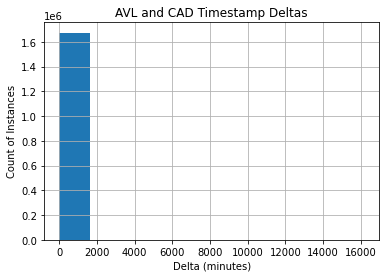

In [33]:
(sort['delta'] / pd.Timedelta(minutes=1)).hist()
deltas = (sort['delta'] / pd.Timedelta(minutes=1))
plt.title('AVL and CAD Timestamp Deltas')
plt.xlabel('Delta (minutes)')
plt.ylabel('Count of Instances');

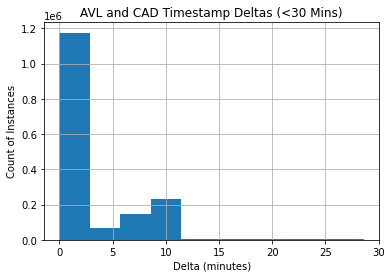

In [34]:
(sort[sort['delta'] < sort['delta'].max()/565]['delta'] / pd.Timedelta(minutes=1)).hist()
plt.title('AVL and CAD Timestamp Deltas (<30 Mins)')
plt.xlabel('Delta (minutes)')
plt.ylabel('Count of Instances');

In [35]:
sort.sort_values(by = 'delta', ascending = False).head(20)

,AVL_IncidentNumber,AVL_UnitID,AVL_UnitStatus,firstavl,CAD_IncidentNumber,CAD_UnitID,CAD_UnitStatus,firstcad,delta
40023,E170333099,R419,DP,2017-02-14 02:37:33,E170333099,R419,DP,2017-02-02 21:10:37,11 days 05:26:56
40017,E170333099,R414,DP,2017-02-13 22:30:27,E170333099,R414,DP,2017-02-03 12:34:19,10 days 09:56:08
39919,E170333099,E419,DP,2017-02-13 02:46:21,E170333099,E419,DP,2017-02-02 21:10:25,10 days 05:35:56
39927,E170333099,E422,DP,2017-02-09 18:43:08,E170333099,E422,DP,2017-02-02 21:21:09,6 days 21:21:59
39948,E170333099,E427,ER,2017-02-09 06:49:29,E170333099,E427,ER,2017-02-03 18:32:47,5 days 12:16:42
40038,E170333099,T441,DP,2017-02-07 18:11:22,E170333099,T441,DP,2017-02-02 21:10:33,4 days 21:00:49
39947,E170333099,E427,DP,2017-02-08 07:18:51,E170333099,E427,DP,2017-02-03 18:31:13,4 days 12:47:38
39973,E170333099,E440,DP,2017-02-09 03:06:54,E170333099,E440,DP,2017-02-04 22:29:11,4 days 04:37:43
39954,E170333099,E431,DP,2017-02-07 18:43:00,E170333099,E431,DP,2017-02-03 18:11:55,4 days 00:31:05
39958,E170333099,E432,DP,2017-02-06 11:00:02,E170333099,E432,DP,2017-02-02 22:49:26,3 days 12:10:36


In [36]:
print(sort['delta'].describe())
print("90th percentile: ", pd.to_timedelta(np.percentile(sort['delta'], 90), unit = "sec"))

count                      1673903
mean     0 days 00:03:49.047632987
std      0 days 00:27:18.527662193
min                0 days 00:00:00
25%                0 days 00:00:28
50%                0 days 00:01:06
75%                0 days 00:06:08
max               11 days 05:26:56
Name: delta, dtype: object
90th percentile:  0 days 00:09:30


## Next steps

- Breakdown visualizations by status (find deltas by the status)
- Make visualizations prettier
- Do analysis at the 90th percentile

In [37]:
uniqueStatus = sort['AVL_UnitStatus'].unique()

Timestamp Deltas Between AVL and CAD Data Summary Stats by Unit Stats
Unit Status: TA
count                       178277
mean     0 days 00:12:36.075954834
std      0 days 00:15:27.553229872
min                0 days 00:00:00
25%                0 days 00:00:45
50%                0 days 00:09:14
75%                0 days 00:15:11
max                0 days 13:10:12
Name: delta, dtype: object

90th Percentile: 0 days 00:35:03

Distribution Plot: 


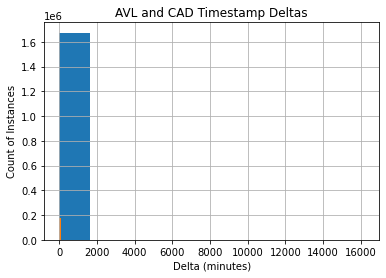

------------------------------------------------------------------------------------------
Unit Status: TR
count                       185215
mean     0 days 00:01:03.075388062
std      0 days 00:01:27.630391558
min                0 days 00:00:00
25%                0 days 00:00:31
50%                0 days 00:00:51
75%                0 days 00:01:16
max                0 days 02:47:58
Name: delta, dtype: object

90th Percentile: 0 days 00:01:48

Distribution Plot: 


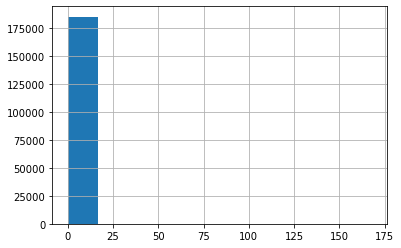

------------------------------------------------------------------------------------------
Unit Status: WP
count                       210825
mean     0 days 00:07:18.461558164
std      0 days 00:02:47.195954826
min                0 days 00:00:00
25%                0 days 00:06:33
50%                0 days 00:07:53
75%                0 days 00:08:36
max                0 days 04:02:40
Name: delta, dtype: object

90th Percentile: 0 days 00:09:03

Distribution Plot: 


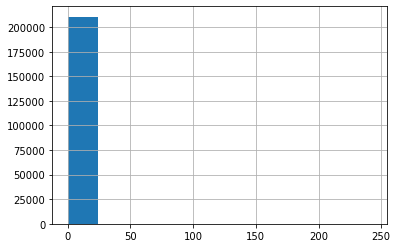

------------------------------------------------------------------------------------------
Unit Status: OS
count                       341735
mean     0 days 00:04:27.772777151
std      0 days 00:10:21.659210134
min                0 days 00:00:00
25%                0 days 00:00:10
50%                0 days 00:01:10
75%                0 days 00:09:30
max                1 days 21:48:56
Name: delta, dtype: object

90th Percentile: 0 days 00:09:49

Distribution Plot: 


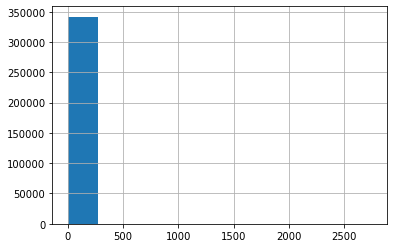

------------------------------------------------------------------------------------------
Unit Status: ER
count                       711500
mean     0 days 00:01:02.235352073
std      0 days 00:09:42.930470774
min                0 days 00:00:00
25%                0 days 00:00:29
50%                0 days 00:00:52
75%                0 days 00:01:20
max                5 days 12:16:42
Name: delta, dtype: object

90th Percentile: 0 days 00:01:54

Distribution Plot: 


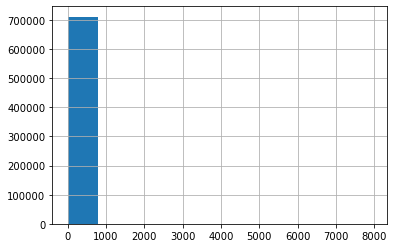

------------------------------------------------------------------------------------------
Unit Status: DP
count                        46275
mean     0 days 00:03:07.955094543
std      0 days 02:32:31.273400187
min                0 days 00:00:00
25%                0 days 00:00:06
50%                0 days 00:00:23
75%                0 days 00:00:59
max               11 days 05:26:56
Name: delta, dtype: object

90th Percentile: 0 days 00:01:32

Distribution Plot: 


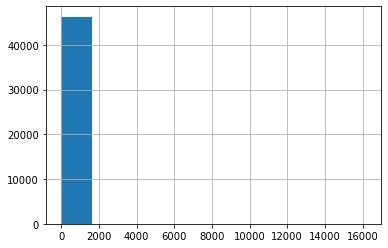

------------------------------------------------------------------------------------------
Unit Status: AK
count                           76
mean     0 days 00:01:18.894736842
std      0 days 00:01:52.294206315
min                0 days 00:00:01
25%                0 days 00:00:15
50%                0 days 00:00:42
75%         0 days 00:01:29.250000
max                0 days 00:09:17
Name: delta, dtype: object

90th Percentile: 0 days 00:02:58

Distribution Plot: 


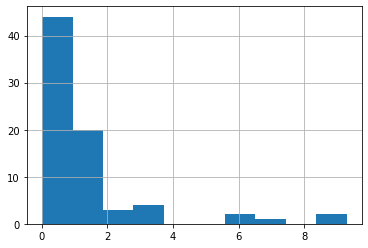

------------------------------------------------------------------------------------------


In [38]:
(sort['delta'] / pd.Timedelta(minutes=1)).hist()
deltas = (sort['delta'] / pd.Timedelta(minutes=1))
plt.title('AVL and CAD Timestamp Deltas')
plt.xlabel('Delta (minutes)')
plt.ylabel('Count of Instances');


print('Timestamp Deltas Between AVL and CAD Data Summary Stats by Unit Stats')
for i in uniqueStatus:
    print('Unit Status: {}'.format(i))
    print(sort[sort['AVL_UnitStatus'] == i]['delta'].describe())
    print()
    print('90th Percentile: {}'.format(
        pd.to_timedelta(np.percentile((sort[sort['AVL_UnitStatus'] == i]['delta']), 90), unit = 'sec' )))
    print()
    print('Distribution Plot: ')
    plt.show((sort[sort['AVL_UnitStatus']==i]['delta']/pd.Timedelta(minutes=1)).hist())
    print('---' * 30)

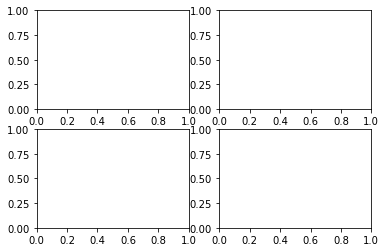

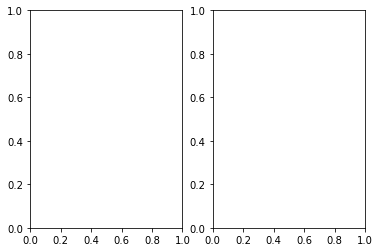

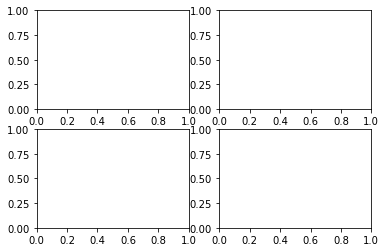

In [39]:
fig, axs = plt.subplots(2, 2)

# using tuple unpacking for multiple Axes
fig, (ax1, ax2) = plt.subplots(1, 2)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

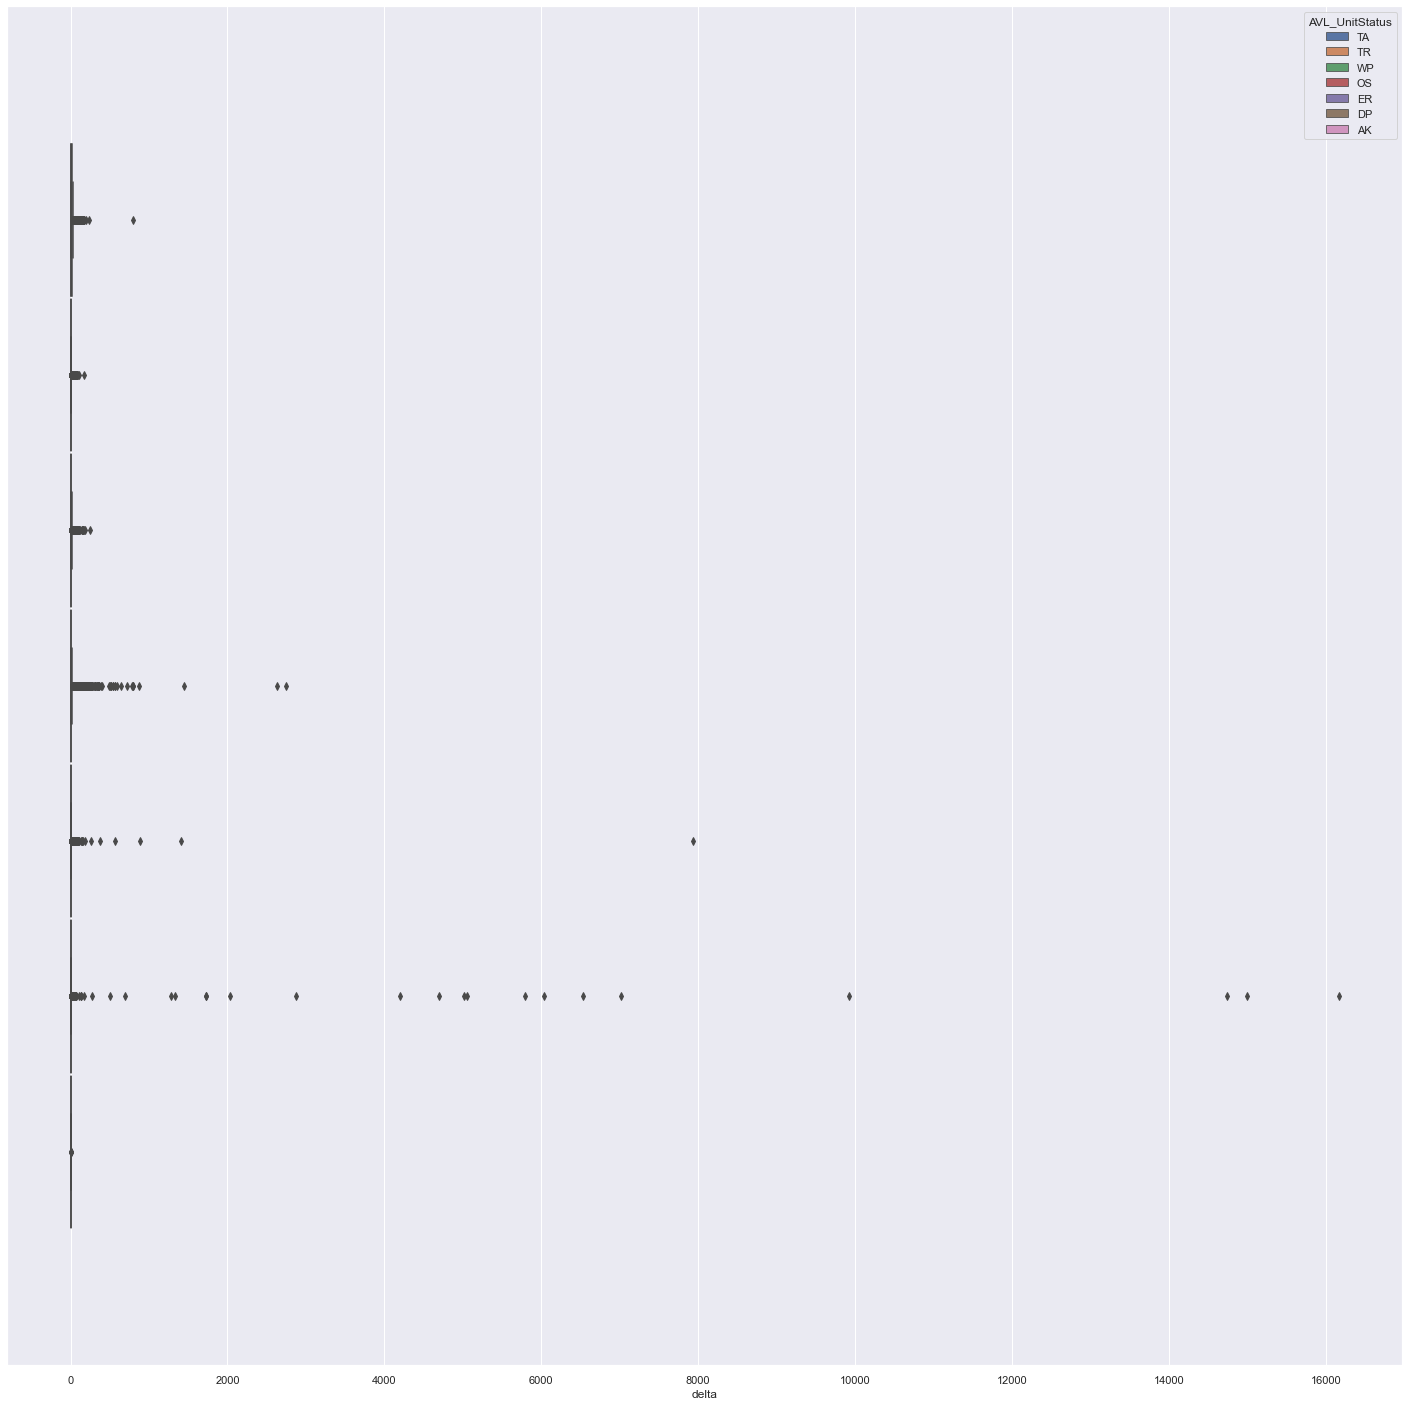

In [59]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


ax = sns.boxplot(x = sort['delta'].dt.total_seconds()/60, y = [""] * len(sort), hue=sort["AVL_UnitStatus"])  # RUN PLOT   
sns.set(rc={'figure.figsize':(10, 25)})
plt.show()

# plt.clf()
# plt.close()

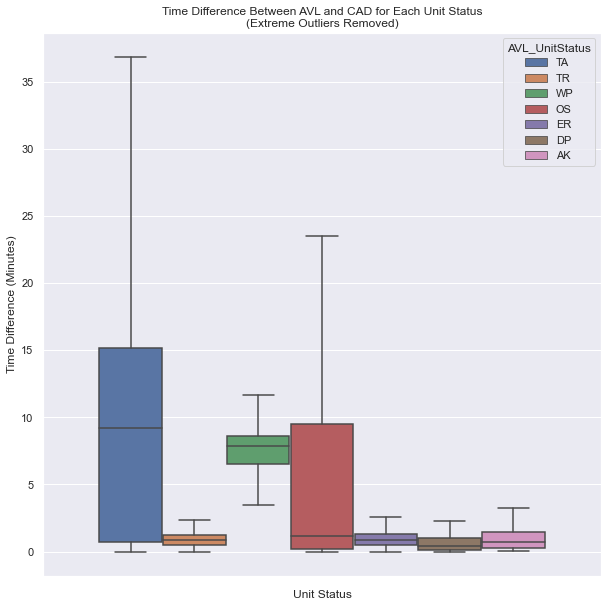

<Figure size 720x720 with 0 Axes>

In [86]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


# ax = sns.boxplot(x = sort['delta'].dt.total_seconds()/60, y = [""] * len(sort), hue=sort["AVL_UnitStatus"], showfliers = False)  # RUN PLOT   
ax = sns.boxplot(y = sort['delta'].dt.total_seconds()/60, x = [""] * len(sort), hue=sort["AVL_UnitStatus"],
                 showfliers = False,)
#                  whis = [0,90])  # RUN PLOT   

sns.set(rc={'figure.figsize':(10,10)})
plt.xlabel('Unit Status')
plt.ylabel('Time Difference (Minutes)')
plt.title('Time Difference Between AVL and CAD for Each Unit Status\n(Extreme Outliers Removed)')
plt.show()

plt.clf()
# plt.close()